# Computer Vision: Plant Seedlings Classification

#### **Demo Project:** The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

#### Author: **Gabriel Egbenya**

##### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import keras

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from tensorflow.keras.callbacks import EarlyStopping                                             #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer                                                 #One hot encoding
from sklearn.metrics import accuracy_score, confusion_matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Reducing the Learning Rate: model improvement technique
from keras.callbacks import ReduceLROnPlateau


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/gdrive/MyDrive/great_learning/PlantSeed_Lab/plantClassData.zip

In [3]:
# Load the image file of the dataset
images = np.load('/content/drive/My Drive/great_learning/PlantSeed_Lab/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/My Drive/great_learning/PlantSeed_Lab/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [4]:
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of images: (4750, 128, 128, 3)
Shape of labels: (4750, 1)


There are 4750 RGB images of shape 128 x 128 X 3, each image is having 3 channels.

In [5]:
# Verify the data
print("First 5 labels:")
labels.head()

First 5 labels:


,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Plotting images using OpenCV and matplotlib

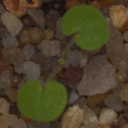

In [ ]:
cv2_imshow(images[5])

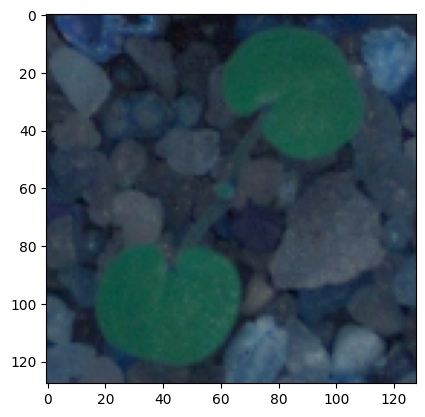

In [ ]:
plt.imshow(images[5])

- We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- Now we will convert these BGR images to RGB images so we could interpret them easily.

## Exploratory Data Analysis

#### **Plotting random images from each of the class**

In [7]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

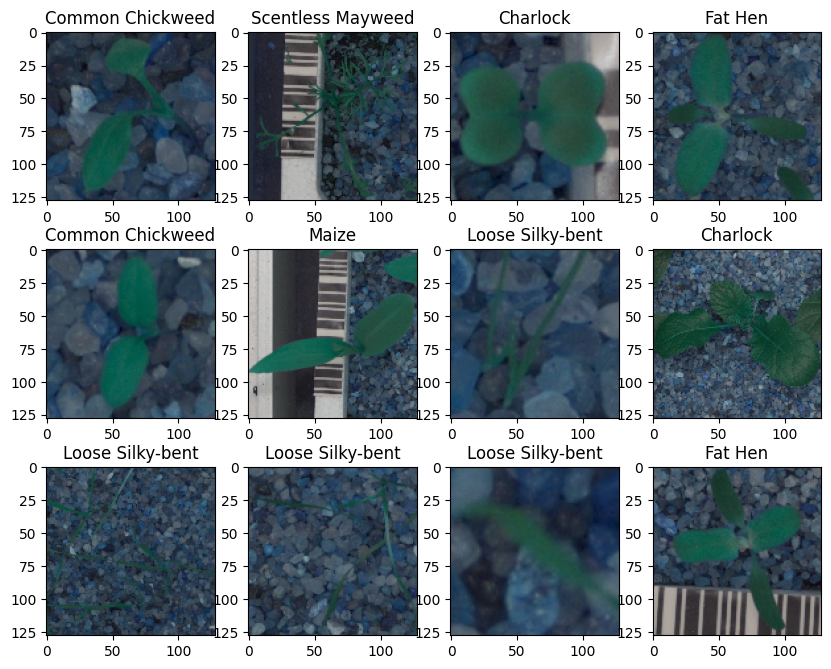

In [8]:
plot_images(images,labels)

<b> Checking for distribution of the target variable

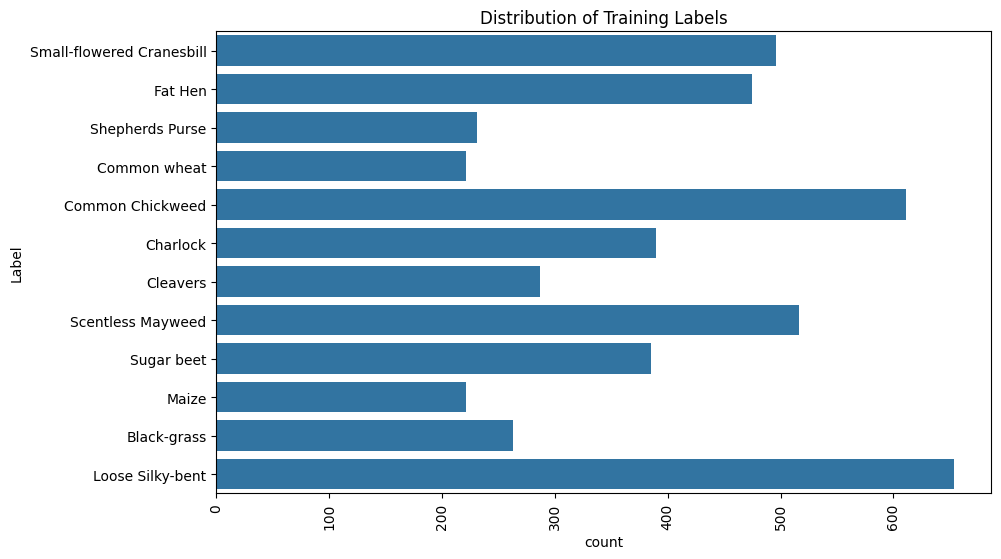


--------------------------------------------------------

Summary statistics of the images:
Mean pixel value: 70.04363745545504
Standard deviation of pixel values: 31.996876308515


In [9]:
# Perform Exploratory Data Analysis (EDA)

# 1. Distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(labels['Label'])
plt.title("Distribution of Training Labels")
plt.xticks(rotation=90)
plt.show()

print('\n--------------------------------------------------------\n')

# 2. Summary statistics of the images
print(f"Summary statistics of the images:")
print(f"Mean pixel value: {np.mean(images)}")
print(f"Standard deviation of pixel values: {np.std(images)}")

- As you can observe from the above plot, the dataset is imbalanced.
- So we can try to use data augmentation techniques or use appropriate evaluation methods like confusion matrix, precision and recall to evaluate the model which is trained on imbalanced data.

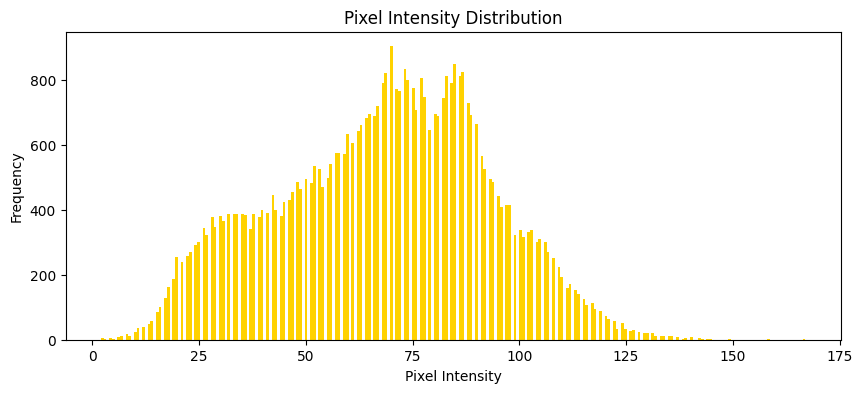

In [10]:
# 3. Displaying a few images with their label distribution
def plot_image_histogram(image):
    plt.figure(figsize=(10, 4))
    plt.hist(image.ravel(), bins=256, color='orange', )
    plt.hist(image.ravel(), bins=256, color='yellow', alpha=0.5)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution')
    plt.show()

# Plot histogram of the first image in the training set
plot_image_histogram(images[0])

# **Dataset Preprocessing And Analysis**

### Convert the BGR images to RGB images.

In [11]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

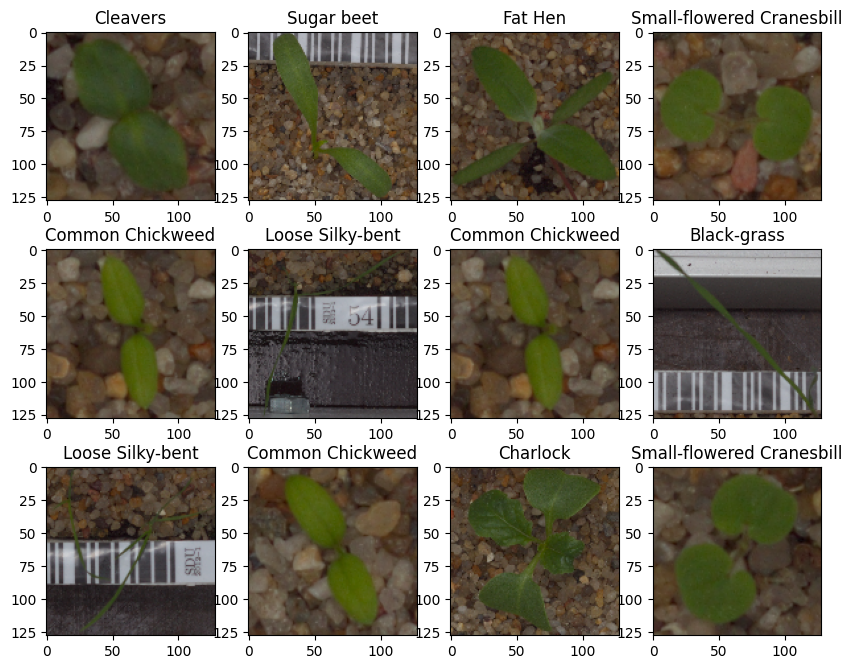

In [12]:
plot_images(images,labels)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [13]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

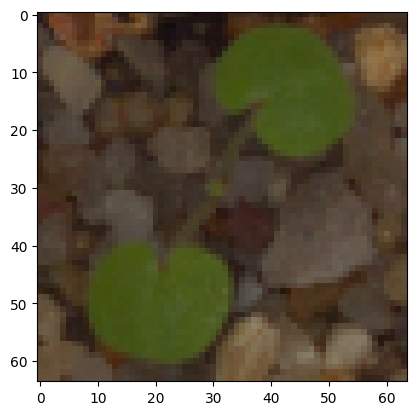

In [14]:
plt.imshow(images_decreased[5])

### Data Preparation for Modeling

**Split the dataset**

- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [15]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [16]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [17]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder


enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [18]:
print(X_train.shape,y_train_encoded.shape)
print(X_val.shape,y_val_encoded.shape)
print(X_test.shape,y_test_encoded.shape)

(3847, 64, 64, 3) (3847, 12)
(428, 64, 64, 3) (428, 12)
(475, 64, 64, 3) (475, 12)


### Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [19]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


In [20]:
print(X_train_normalized.shape,y_train_encoded.shape)
print(X_val_normalized.shape,y_val_encoded.shape)
print(X_test_normalized.shape,y_test_encoded.shape)

(3847, 64, 64, 3) (3847, 12)
(428, 64, 64, 3) (428, 12)
(475, 64, 64, 3) (475, 12)


In [21]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU not available, using CPU.")

GPU is available.


## Model Building

**Convolutional Neural Network (CNN)** -
Let's create a CNN model sequentially, where we will be adding the layers one after another.

In [25]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [26]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [27]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))


# Adding max pooling to reduce the size of output of first conv layer
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))


model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

### <b> Fitting the model on the train data

In [28]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 9s - loss: 2.4544 - accuracy: 0.1071 - val_loss: 2.4368 - val_accuracy: 0.1379 - 9s/epoch - 75ms/step
Epoch 2/30
121/121 - 1s - loss: 2.3851 - accuracy: 0.1708 - val_loss: 2.1445 - val_accuracy: 0.3481 - 1s/epoch - 11ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0825 - accuracy: 0.3028 - val_loss: 1.8432 - val_accuracy: 0.3902 - 1s/epoch - 10ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9073 - accuracy: 0.3358 - val_loss: 1.7515 - val_accuracy: 0.4486 - 1s/epoch - 9ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8256 - accuracy: 0.3462 - val_loss: 1.5544 - val_accuracy: 0.5070 - 1s/epoch - 9ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7015 - accuracy: 0.3985 - val_loss: 1.5000 - val_accuracy: 0.4953 - 1s/epoch - 9ms/step
Epoch 7/30
121/121 - 1s - loss: 1.6721 - accuracy: 0.4073 - val_loss: 1.3906 - val_accuracy: 0.5210 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6022 - accuracy: 0.4136 - val_loss: 1.3167 - val_accuracy: 0.5444 - 1s/epoch - 9ms/step
Epoch 9/30
121/121 - 

### **Model Evaluation**

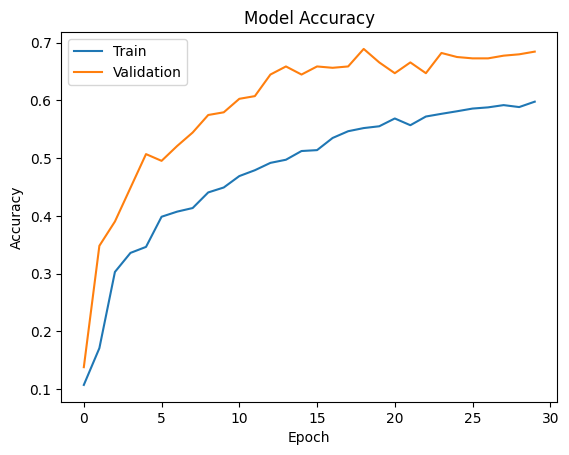

In [29]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was good(70%) but the validation accuracy was not good(61%).**
*   The shows that the model is unstable.
* Let's check the model performance on test set.





### **Evaluating the model on test data**

In [30]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.9878 - accuracy: 0.6947 - 319ms/epoch - 21ms/step


### **Generating the predictions using test data**

In [31]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 4ms/step


### **Plotting the Confusion Matrix**


*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





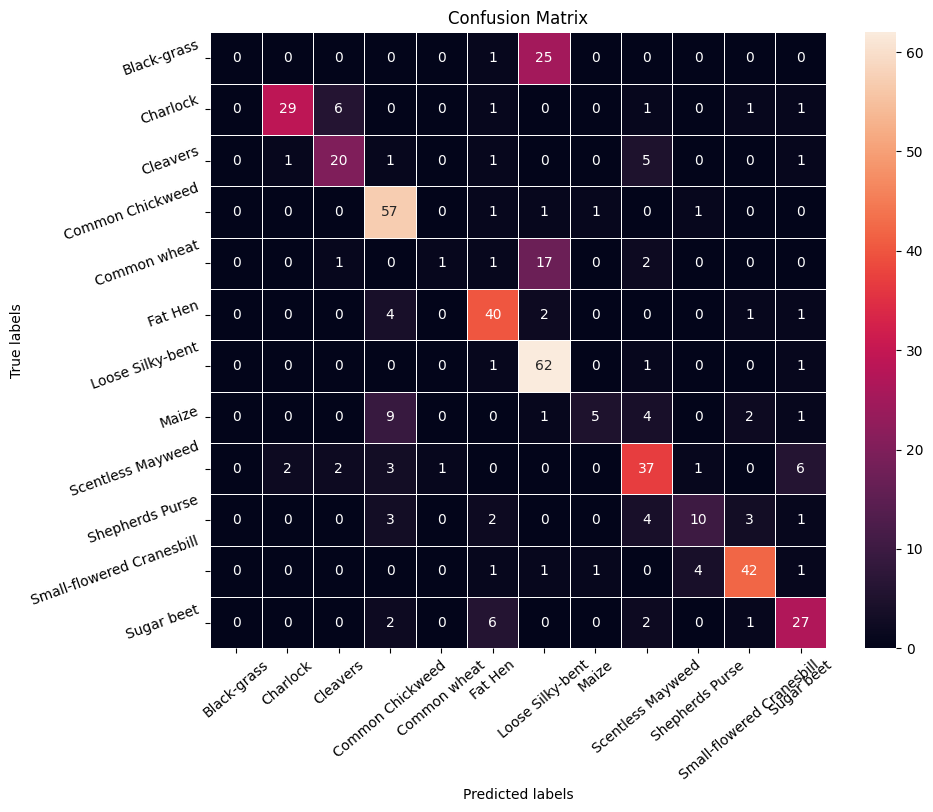

In [32]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes common wheat,  black-grass, and shepherds-purse are not well classified.
- We can also observe that classification of black-grass is not being done, the black-grass is usually thin so it might even be a reason as the classifier is not able to classify this class.

In [33]:
from sklearn import datasets, metrics, svm

# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.91      0.74      0.82        39
           2       0.69      0.69      0.69        29
           3       0.72      0.93      0.81        61
           4       0.50      0.05      0.08        22
           5       0.73      0.83      0.78        48
           6       0.57      0.95      0.71        65
           7       0.71      0.23      0.34        22
           8       0.66      0.71      0.69        52
           9       0.62      0.43      0.51        23
          10       0.84      0.84      0.84        50
          11       0.68      0.71      0.69        38

    accuracy                           0.69       475
   macro avg       0.64      0.59      0.58       475
weighted avg       0.66      0.69      0.65       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [36]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

## Model 2
## Data Augmentation

In [37]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [38]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [39]:

# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

<b> Fitting the model on the train data

In [40]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

history2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,callbacks=[learning_rate_reduction])



Epoch 1/30
60/60 [==============================] - 9s 108ms/step - loss: 2.1376 - accuracy: 0.2477 - val_loss: 2.4008 - val_accuracy: 0.1916 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 4s 70ms/step - loss: 1.7484 - accuracy: 0.3825 - val_loss: 2.2545 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 5s 78ms/step - loss: 1.5635 - accuracy: 0.4446 - val_loss: 2.2292 - val_accuracy: 0.1986 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 83ms/step - loss: 1.4396 - accuracy: 0.4925 - val_loss: 2.0801 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 4s 69ms/step - loss: 1.3516 - accuracy: 0.5155 - val_loss: 1.8021 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 6s 98ms/step - loss: 1.2720 - accuracy: 0.5570 - val_loss: 1.6431 - val_accuracy: 0.6449 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 4s 69ms/step - loss: 1.

**Model Evaluation**

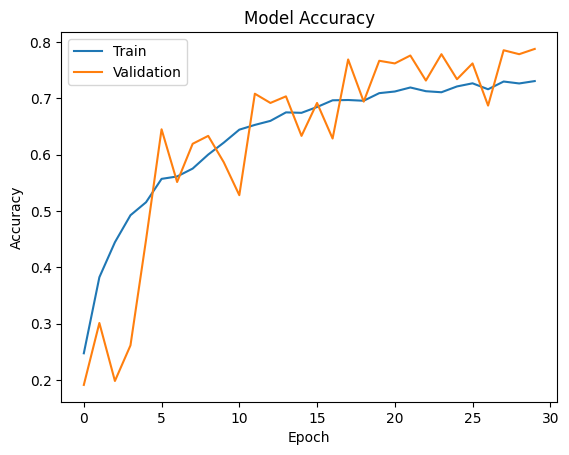

In [41]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [43]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7783 - accuracy: 0.7516 - 255ms/epoch - 17ms/step


* We can observe that our accuracy has improved compared to our previous model.
* The model is giving a generalized performance.

In [45]:
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


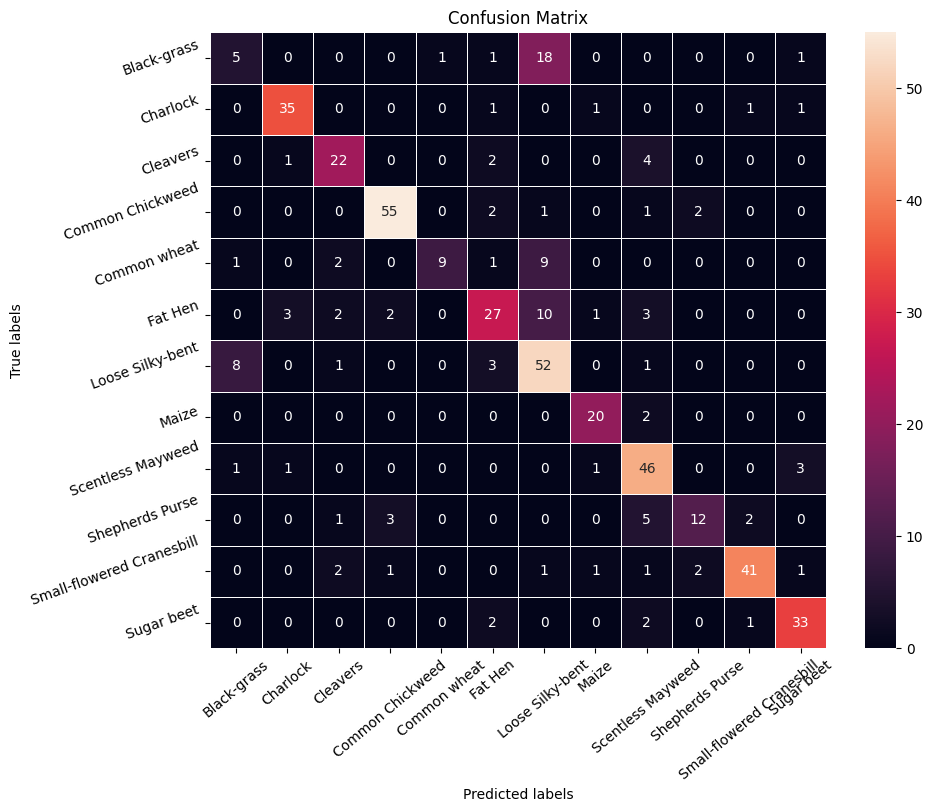

In [47]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Observation:**
- The confusion matrix appears to be improving as well, however there is still some confusion with the black-grass, common-wheat and shepherds purse species.
- We can observe that this model has outperformed our previous model and this has given improved performance than our previous model.

In [48]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.19      0.24        26
           1       0.88      0.90      0.89        39
           2       0.73      0.76      0.75        29
           3       0.90      0.90      0.90        61
           4       0.90      0.41      0.56        22
           5       0.69      0.56      0.62        48
           6       0.57      0.80      0.67        65
           7       0.83      0.91      0.87        22
           8       0.71      0.88      0.79        52
           9       0.75      0.52      0.62        23
          10       0.91      0.82      0.86        50
          11       0.85      0.87      0.86        38

    accuracy                           0.75       475
   macro avg       0.75      0.71      0.72       475
weighted avg       0.76      0.75      0.74       475



# **Transfer Learning using google/vit-base-patch16-224**

In [49]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from transformers import ViTConfig
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU not available, using CPU.")

GPU is available.


In [51]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [52]:
# Initialize the ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [53]:
# Create a train-test split
# Encode labels as integers
label_encoder = {label: idx for idx, label in enumerate(labels['Label'].unique())}
label_decoder = {idx: label for label, idx in label_encoder.items()}
encoded_labels = labels['Label'].map(label_encoder)

In [54]:
# Split the data into training and test sets
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)


In [55]:
# Function to visualize some images with their labels
def visualize_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(label_decoder[labels.iloc[i]])
        plt.axis('off')
    plt.show()

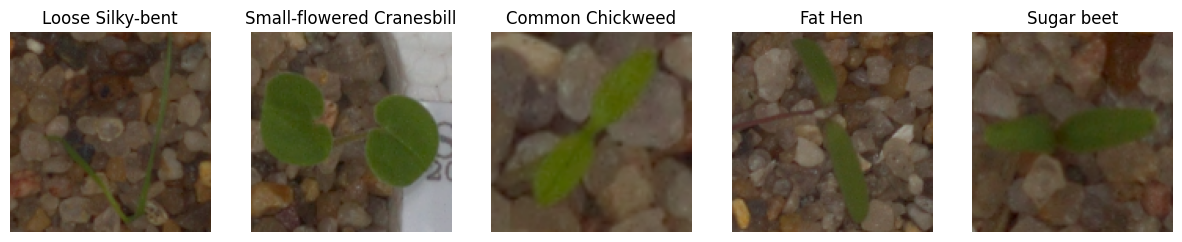

In [56]:
	# Visualize the first few images and their labels
visualize_images(X_train_en, y_train_en, num_images=5)

Shape of a single image: (64, 64, 3)
Min pixel value: 0
Max pixel value: 112


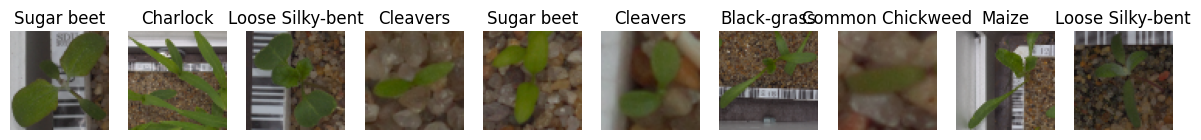

In [57]:
# Additional EDA
def additional_eda(images):
    # Check the shape of a single image
    print(f"Shape of a single image: {images[0].shape}")

    # Display min and max pixel values for the first image
    print(f"Min pixel value: {np.min(images[0])}")
    print(f"Max pixel value: {np.max(images[0])}")

    # Display random samples of images
    indices = np.random.choice(range(len(images)), 10, replace=False)
    visualize_images(images[indices], y_train_en.iloc[indices], num_images=10)

additional_eda(X_train)

In [58]:
# Preprocess the data
def preprocess_images(images):
    return np.array([feature_extractor(image, return_tensors="tf")['pixel_values'][0].numpy() for image in images])

# Run feature extraction on GPU if available
with tf.device('/GPU:0'):
    X_train_processed = preprocess_images(X_train_en)
    X_test_processed = preprocess_images(X_test_en)

In [59]:
X_train_en.shape

(3800, 128, 128, 3)

In [60]:
X_train_processed.shape

(3800, 3, 224, 224)

In [61]:
# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_en, num_classes=len(label_encoder))
y_test_one_hot = tf.keras.utils.to_categorical(y_test_en, num_classes=len(label_encoder))

In [62]:
# Define the ViT model
class PlantClassifier_VIT_pre(tf.keras.Model):
    def __init__(self, num_classes=2):
        super(PlantClassifier_VIT_pre, self).__init__()

        self.transformer = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

        # Classification head
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        outputs = self.transformer(x)

        # cls_output = outputs.last_hidden_state[:, 0, :]

        # Pass the transformer output through the classifier
        x = self.classifier(outputs.logits)
        return x

with tf.device('/GPU:0'):  # Explicitly use GPU if available
    # model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(label_encoder))
    model3 = PlantClassifier_VIT_pre(num_classes=len(label_encoder))


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [63]:
# Compile the model
model3.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0002),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [65]:
# Train the model
batch_size = 32
epochs = 24


history3 = model3.fit(datagen.flow(X_train_processed, y_train_one_hot, batch_size=batch_size),
          validation_data=(X_test_processed, y_test_one_hot),
          epochs=epochs)

Epoch 1/24
119/119 [==============================] - 226s 1s/step - loss: 1.2749 - accuracy: 0.5718 - val_loss: 0.7020 - val_accuracy: 0.7379
Epoch 2/24
119/119 [==============================] - 170s 1s/step - loss: 0.5332 - accuracy: 0.8084 - val_loss: 0.4671 - val_accuracy: 0.8379
Epoch 3/24
119/119 [==============================] - 169s 1s/step - loss: 0.4929 - accuracy: 0.8329 - val_loss: 0.9444 - val_accuracy: 0.7011
Epoch 4/24
119/119 [==============================] - 161s 1s/step - loss: 0.4154 - accuracy: 0.8550 - val_loss: 0.4422 - val_accuracy: 0.8400
Epoch 5/24
119/119 [==============================] - 161s 1s/step - loss: 0.2743 - accuracy: 0.9003 - val_loss: 0.4284 - val_accuracy: 0.8495
Epoch 6/24
119/119 [==============================] - 161s 1s/step - loss: 0.2594 - accuracy: 0.9105 - val_loss: 0.6232 - val_accuracy: 0.8253
Epoch 7/24
119/119 [==============================] - 169s 1s/step - loss: 0.2911 - accuracy: 0.8982 - val_loss: 0.4447 - val_accuracy: 0.8432

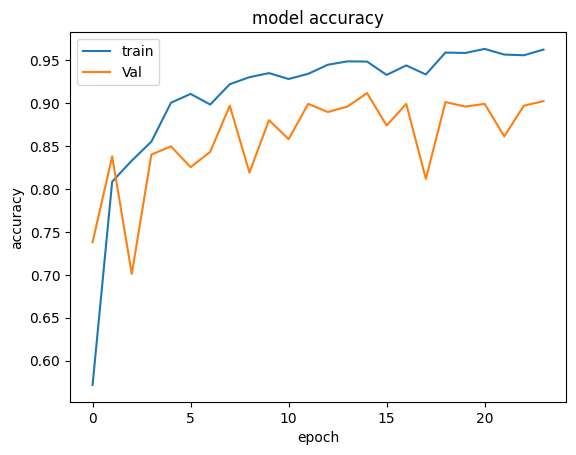

In [66]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [67]:
# Evaluate the model
with tf.device('/GPU:0'):  # Explicitly use GPU if available
    loss, accuracy = model3.evaluate(X_test_processed, y_test_one_hot)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

30/30 [==============================] - 12s 408ms/step - loss: 0.3036 - accuracy: 0.9021
Test Accuracy: 90.21%


In [69]:

y_pred=model3.predict(X_test_processed)

30/30 [==============================] - 20s 404ms/step


* We can observe that our accuracy has improved greatly compared to our previous models.
* The model is giving a generalized performance.

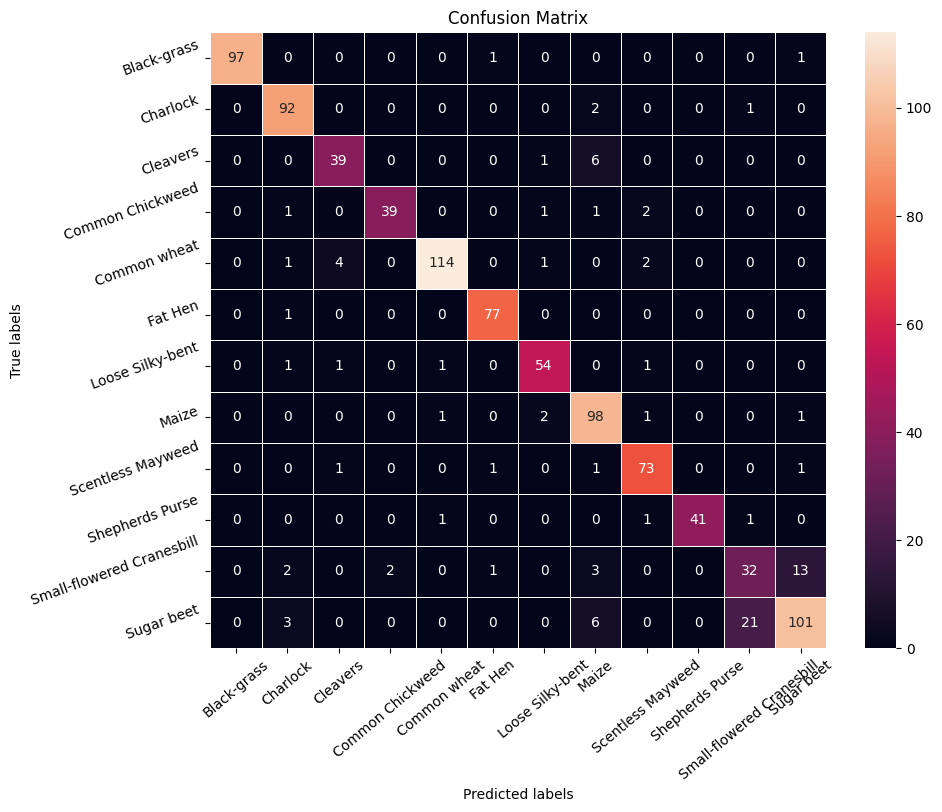

In [72]:

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_one_hot,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Observation:**
- The confusion matrix appears to be improving as well, however there is still some confusion with the sugar beat and small-flowered cranesbill.
- We can observe that this model has outperformed our previous model and this has given improved performance than our previous model.

In [71]:
from sklearn import datasets, metrics, svm

# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        99
           1       0.91      0.97      0.94        95
           2       0.87      0.85      0.86        46
           3       0.95      0.89      0.92        44
           4       0.97      0.93      0.95       122
           5       0.96      0.99      0.97        78
           6       0.92      0.93      0.92        58
           7       0.84      0.95      0.89       103
           8       0.91      0.95      0.93        77
           9       1.00      0.93      0.96        44
          10       0.58      0.60      0.59        53
          11       0.86      0.77      0.81       131

    accuracy                           0.90       950
   macro avg       0.90      0.90      0.90       950
weighted avg       0.90      0.90      0.90       950



# **Inference**

In [73]:
# Perform inference
def predict(image):
    image_processed = feature_extractor(image, return_tensors="tf")['pixel_values']
    logits = model3(image_processed)
    predicted_class_idx = tf.argmax(logits, axis=-1).numpy()[0]
    return list(label_encoder.keys())[list(label_encoder.values()).index(predicted_class_idx)]

In [74]:
def decode_true_label(number0_11):
  true_label = y_test_en.iloc[number0_11]
  return list(label_encoder.keys())[list(label_encoder.values()).index(true_label)]

In [75]:
# Example inference
example_image = X_test_en[2]  # Use an image from the test set as an example
true_ytest_label = 2
predicted_label = predict(example_image)
true_label = decode_true_label(true_ytest_label)
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")

Predicted label: Sugar beet
True label: Sugar beet


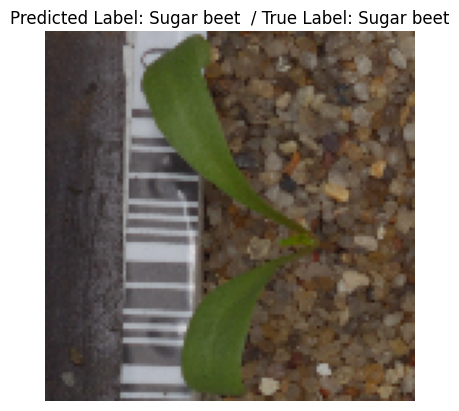

In [76]:
# Visualize the example image and its predicted label
import matplotlib.pyplot as plt

plt.imshow(example_image)
plt.title(f"Predicted Label: {predicted_label}  / True Label: {true_label}")
plt.axis('off')
plt.show()


## Final Model

- According to the confusion matrix and accuracy curve, the transfer learning model has outperformed other models.
- Thus we can say that it is our best model and we can use this model to predict and visualize some test images.

### Visualizing the prediction

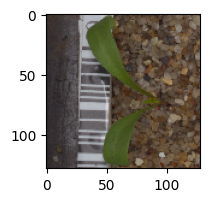

Predicted label: Sugar beet
True label: Sugar beet


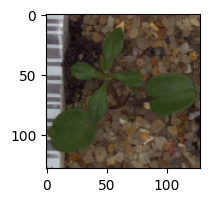

Predicted label: Cleavers
True label: Cleavers


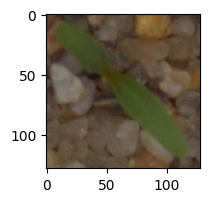

Predicted label: Sugar beet
True label: Sugar beet


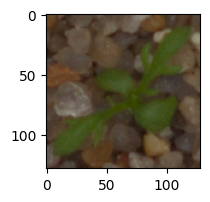

Predicted label: Scentless Mayweed
True label: Scentless Mayweed


In [77]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test_en[2])
plt.show()

# Example inference
example_image = X_test_en[2]  # Use an image from the test set as an example
true_ytest_label = 2
predicted_label = predict(example_image)
true_label = decode_true_label(true_ytest_label)
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")





# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test_en[33])
plt.show()

# Example inference
example_image = X_test_en[33]  # Use an image from the test set as an example
true_ytest_label = 33
predicted_label = predict(example_image)
true_label = decode_true_label(true_ytest_label)
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")





# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test_en[59])
plt.show()

# Example inference
example_image = X_test_en[59]  # Use an image from the test set as an example
true_ytest_label = 59
predicted_label = predict(example_image)
true_label = decode_true_label(true_ytest_label)
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")




# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test_en[36])
plt.show()

# Example inference
example_image = X_test_en[36]  # Use an image from the test set as an example
true_ytest_label = 36
predicted_label = predict(example_image)
true_label = decode_true_label(true_ytest_label)
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")

**Observations**
- We observe that all the above images were classified correctly.
- This shows that transfer learning has helped in creating a generalized model.

## Actionable Insights and Business Recommendations

- We can observe from the confusion matrix of all the models that our ViT model was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the ViT model is 90%.
- Data Augmentation has also helped in improving the model.
- Simply employing the transfer learning model can produce a better outcome than any ordinary CNN.

_____

## Thanks for reading
**Courtesy: Gabriel Egbenya**